In [246]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from model import SimonModel, StageModel, MageModel
import os
from ipdb import set_trace as bp
from tqdm import tqdm 
def process_stages(stages):
    stages[stages < 0] = 0
    stages[stages > 5] = 0
    stages = stages.astype(int)
    mapping = np.array([0, 2, 2, 3, 3, 1, 0, 0, 0, 0], int)
    # mapping = np.array([0, 2, 2, 3, 3, 1, 0, 0, 0, 0], int) 
    # mapping = np.array([0, 1, 2, 3, 3, 4, 0, 0, 0, 0, 0], np.int64)
    return mapping[stages]
def get_date_from_filename(filename):
    # Extract the date part from the filename
    date_part = filename.split('.')[0].split('-')
    return ''.join(date_part)

def get_ordered_nights_list(nights_dir):
    unordered_nights_list = os.listdir(nights_dir)
    return sorted(unordered_nights_list, key=get_date_from_filename, reverse=False)

def get_predicted_prob(model, np_file_path, args):
    x = dict(np.load(np_file_path))
    if args.stage_input:
        input_size = 2 * 60 * 10
        feature = x['data']
        stages_fs = x['fs']
        # factor = round(stages_fs * 30)
        # feature = feature[::factor]
        feature[feature < 0] = 0
        feature = feature.astype(int)
        # if len(np.unique(feature)) > 4:
        # from IPython.core.debugger import Pdb; Pdb().set_trace()
        # feature = process_stages(feature)
        
        if len(feature) > input_size:
            feature = feature[:input_size]
        else:
            feature = np.concatenate((feature, np.zeros((input_size-len(feature)),dtype=int)), axis=0)
    else:
        feature = x['decoder_eeg_latent'].squeeze(0)
        if feature.shape[0] >= 150:
            feature = feature[:150, :]
        else:
            feature = np.concatenate((feature, np.zeros((150-feature.shape[0],feature.shape[-1]),dtype=np.float32)), axis=0)

    # feature = file['decoder_eeg_latent'].squeeze(0)
    # if feature.shape[0] >= 150:
    #     feature = feature[:150, :]
    # else:
    #     feature = np.concatenate((feature, np.zeros((150-feature.shape[0],feature.shape[-1]),dtype=np.float32)), axis=0)
    feature = torch.from_numpy(feature).to(args.device)
    #bp()
    feature = torch.unsqueeze(feature, 0)
    with torch.no_grad():
        output = torch.sigmoid(model(feature))
    output = output.cpu().detach().numpy()
    return output[0][0]

class Object(object):
    pass

In [251]:
antidep_dict = {
'NIHPV178MDAUT': 'SNRI venlafaxine',
'NIHCJ555VCWZY': 'SNRI venlafaxine',
'NIHHD991PGRJC': 'TCA mirtazapine',
'NIHBL760KMGXL': 'SSRI escitalopram, SARI trazodone',
'NIHNT823CHAC3': 'SSRI escitalopram',
'NIHXN782DBBP7': 'SSRI fluoxetine',
'NIHYM875FLXFF': 'SSRI fluoxetine',
'NIHCX409ZDTJU': 'SSRI escitalopram',
'NIHPX213JXJZC': 'SSRI sertraline',
'NIHVA109LWXMF': 'SSRI sertraline',
'NIHXN551LBFMK': 'SSRI paroxetine',
'NIHEP519MZAEZ': 'SSRI fluoxetine',
'NIHFW795KLATW': 'SSRI paroxetine, SSRI sertraline', 
'NIHPT334YGJLK': 'SSRI paroxetine, SNRI desvenlafaxine',
'NIHAV871KZCVE': 'SSRI paroxetine',
'NIHMR963TPLWF': 'SSRI paroxetine, SSRI sertraline',
'NIHJW557ZEUZV': 'control',
'NIHMF399WYNH5': 'control',
'NIHAV025ZCBGB': 'control',
'NIHBY076JZFYN': 'control',
'NIHEB701YGBEC': 'control',
'NIHFT628PHTAY': 'control',
'NIHHG558EJJMM': 'control',
'NIHRY949ZYWHQ': 'control',
'NIHXB175YAGF7': 'control',
'NIHYW557MLDFE': 'control',
'NIHZT156UUPLX': 'control',
'NIHGK080AGLJH': 'control',
'NIHND126MXDGP': 'control',
'NIHBE740TFYAH': 'control',
'NIHNX715KUVY8': 'control',
'NIHFX695VBHFM': 'control',
'NIHDW178UFZHB': 'control',
'NIHTK278VZHYL': 'control',
'NIHGA312KVEC2': 'control',
'NIHWR605ZHTE7': 'control',
                
'NIHKH638RXUVN': 'control', 
'NIHDL154KMBMU': 'control'}

BENZOS = {
'NIHCJ555VCWZY' : 'clonazepam' ,
'NIHEP519MZAEZ' : 'clonazepam' ,
'NIHET354BPVAV' : 'clonazepam' ,
'NIHFW795KLATW' : 'clonazepam' ,
'NIHHD991PGRJC' : 'mirtazapine clonazepam' ,
'NIHHY970PYCFA' : 'clonazepam' ,
'NIHHZ774ENCA5' : 'diazepam alprazolam' ,
'NIHMF399WYNH5' : 'diazepam' ,
'NIHPT334YGJLK' : 'lorazepam' ,
'NIHRN569XFWML' : 'diazepam' ,
'NIHVJ344PHVFH' : 'lorazepam' ,
'NIHXN551LBFMK' : 'alprazolam' ,
'NIHXN782DBBP7' : 'clonazepam' ,
'NIHYA889LELYV' : 'alprazolam' ,
}

CONTROLS = {    'NIHAV025ZCBGB': 58,
                'NIHBL760KMGXL': 33,
                'NIHBY076JZFYN': 71,
                'NIHEB701YGBEC': 40,
                'NIHFT628PHTAY': 70,
                'NIHHG558EJJMM': 58,
                'NIHJW557ZEUZV': 65,
                'NIHKH638RXUVN': 71,
                'NIHNT823CHAC3': 62,
                'NIHRY949ZYWHQ': 87,
                'NIHXB175YAGF7': 72,
                'NIHXN782DBBP7': 69,
                'NIHYM875FLXFF': 73,
                'NIHYW557MLDFE': 66,
                'NIHZT156UUPLX': 72}

Starting with the Stage Model 

In [249]:
ALL_MODELS = {'SimonModel':{}, 'StageModel':{}, 'MageModel':{}, 'BenzoModel':{}}



encoding_path = "/data/netmit/wifall/ADetect/mage-inference/20230626-mage-br-eeg-cond-8192x32-ce-iter1-alldata-eegps256x8-br1d-1layerbbenc-maskpad-thoraxaug/iter1-temp0.0-mr1.0/udall/abdominal_c4_m1"
stage_encoding_path = "/data/netmit/wifall/ADetect/data/udall/stage"

udall_filenames = os.listdir(encoding_path)
pids = [filename.split('data_')[1] for filename in udall_filenames]

# best antidep model (currently)
# model_path = "/data/scratch/alimirz/2023/SIMON/TENSORBOARD/exp_lr_0.002_w_1.0,2.5_ds_eeg_bs_16_epochs_2_dpt_0.0_fold0_256,64,16_heads4bce_tuned_relu_081123_final/lr_0.002_w_1.0,2.5_bs_16_heads4_0.0_attbce_tuned_relu_081123_final_epochs2_fold0.pt"
ALL_MODELS['SimonModel']['model_path'] = "/data/scratch/alimirz/2023/SIMON/TENSORBOARD/CONV_MODEL/exp_lr_0.002_w_1.0,2.5_ds_eeg_bs_16_epochs_15_dpt_0.0_fold0_256,64,16_heads4_shhs1_pos_added_PEamp_1_Model_simonmodel_kernelsize_5_featuredim_16_numtokenheads_4/lr_0.002_w_1.0,2.5_bs_16_heads4_0.0_attshhs1_pos_added_epochs15_fold0_epoch_2.pt"
# path for best model just on shhs2
##"/data/scratch/alimirz/2023/SIMON/TENSORBOARD/AUTOMATIC_TUNING/exp_lr_0.002_w_1.0,2.5_ds_eeg_bs_16_epochs_15_dpt_0.0_fold0_256,64,16_heads4_08-22-23_fixedpe_PHASE2-TUNE2-fc3_BCE_PEamp_1/lr_0.002_w_1.0,2.5_bs_16_heads4_0.0_att08-22-23_fixedpe_PHASE2-TUNE2-fc3_BCE_epochs15_fold0.pt"
args = Object()
args.label = "antidep"; args.num_classes = 1
args.num_heads = 4; args.hidden_size = 8; args.fc2_size = 32; args.dropout = 0.0 # do these even matter?
args.pe_learned = False; args.pe_fixed = True; args.PE_amplitude=1; args.fc1_size = 8; args.device = torch.device('cuda')
args.stage_input = False; args.no_attention = False
ALL_MODELS['SimonModel']['args'] = args 
simonmodel = SimonModel(args).to(args.device)
state_dict = torch.load(ALL_MODELS['SimonModel']['model_path'])

simonmodel.load_state_dict(state_dict)
ALL_MODELS['SimonModel']['model'] = simonmodel 


ALL_MODELS['StageModel']['model_path'] = "/data/scratch/alimirz/2023/SIMON/TENSORBOARD/CONV_MODEL/exp_lr_0.002_w_1.0,5_ds_eeg_bs_64_epochs_5_dpt_0.0_fold0_256,64,16_heads1_FIXED_TUNING_SAVED_PEamp_1_Model_stagemodel_kernelsize_5_featuredim_16_numtokenheads_4/lr_0.002_w_1.0,5_bs_64_heads1_0.0_attFIXED_TUNING_SAVED_epochs5_fold0_epoch_2.pt"
args = Object()
args.label = "antidep"; args.num_classes = 1
args.num_heads = 1; args.dropout = 0.0 # do these even matter?
args.device = torch.device('cuda')
args.stage_input = True; args.no_attention = False
ALL_MODELS['StageModel']['args'] = args 
stagemodel = StageModel(args, attn_dropout=0.0).to(args.device)
state_dict = torch.load(ALL_MODELS['StageModel']['model_path'])
stagemodel.load_state_dict(state_dict)
# from IPython.core.debugger import Pdb; Pdb().set_trace()
ALL_MODELS['StageModel']['model'] = stagemodel 


ALL_MODELS['MageModel']['model_path'] = "/data/scratch/alimirz/2023/SIMON/TENSORBOARD/CONV_MODEL/exp_lr_0.0002_w_1.0,1.0_ds_eeg_bs_48_epochs_15_dpt_0.2_fold0_256,64,16_heads4_MAGE_BUGFIX_FINAL_PEamp_1_Model_magemodel_kernelsize_5_featuredim_8_numtokenheads_4/lr_0.0002_w_1.0,1.0_bs_48_heads4_0.2_attMAGE_BUGFIX_FINAL_epochs15_fold0_epoch_6.pt"
args = Object()
args.label = "antidep"; args.num_classes = 1
args.num_heads = 4; args.dropout = 0.0
args.num_token_heads = 4; args.feature_dim = 8
args.device = torch.device('cuda')
args.stage_input = False; args.no_attention = False
ALL_MODELS['MageModel']['args'] = args 
magemodel = MageModel(args, attn_dropout=0.0).to(args.device)
state_dict = torch.load(ALL_MODELS['MageModel']['model_path'])
magemodel.load_state_dict(state_dict)
ALL_MODELS['MageModel']['model'] = magemodel 


ALL_MODELS['BenzoModel']['model_path'] = "/data/scratch/alimirz/2023/SIMON/TENSORBOARD/CONV_MODEL/exp_lr_0.0002_w_1.0,1.0_ds_eeg_bs_48_epochs_15_dpt_0.2_fold0_256,64,16_heads4_MAGE_BUGFIX_shhs1pos_BENZO_PEamp_1_Model_magemodel_kernelsize_5_featuredim_8_numtokenheads_4/lr_0.0002_w_1.0,1.0_bs_48_heads4_0.2_attMAGE_BUGFIX_shhs1pos_BENZO_epochs15_fold0_epoch_14.pt"
args = Object()
args.label = "benzo"; args.num_classes = 1
args.num_heads = 4; args.dropout = 0.0
args.num_token_heads = 4; args.feature_dim = 8
args.device = torch.device('cuda')
args.stage_input = False; args.no_attention = False
ALL_MODELS['BenzoModel']['args'] = args 
benzomodel = MageModel(args, attn_dropout=0.0).to(args.device)
state_dict = torch.load(ALL_MODELS['BenzoModel']['model_path'])
benzomodel.load_state_dict(state_dict)
ALL_MODELS['BenzoModel']['model'] = benzomodel 



In [250]:
simonmodel.eval()
magemodel.eval()
stagemodel.eval()
benzomodel.eval() 

# path = '/data/scratch/scadavid/projects/data/udall/'
path = '/data/scratch/alimirz/2023/SIMON/udall/'
# if not os.path.exists(path):
#     os.makedirs(path)

# new_files = ['PD_Hao_data_NIHND126MXDGP', 'PD_Hao_data_NIHBE740TFYAH', 'PD_Hao_data_NIHPT334YGJLK', 'PD_Hao_data_NIHDW178UFZHB', 'PD_Hao_data_NIHHD991PGRJC', 'PD_Hao_data_NIHFW795KLATW']
all_outputs = {}
all_dates = {}

for filename in tqdm(udall_filenames):
# for filename in new_files: # filenames are really folder names
    night_dir = os.path.join(encoding_path, filename)
    ordered_night_files = get_ordered_nights_list(night_dir)
    
    # for night_file in ordered_night_files:
    #     prob = get_predicted_prob(model, night_file)

    stageprobs = [get_predicted_prob(stagemodel, os.path.join(stage_encoding_path, filename, night_file), args=ALL_MODELS['StageModel']['args']) for night_file in ordered_night_files]
    mageprobs = [get_predicted_prob(magemodel, os.path.join(encoding_path, filename, night_file), args=ALL_MODELS['MageModel']['args']) for night_file in ordered_night_files]
    benzoprobs = [get_predicted_prob(benzomodel, os.path.join(encoding_path, filename, night_file), args=ALL_MODELS['BenzoModel']['args']) for night_file in ordered_night_files]
    simonprobs = [get_predicted_prob(simonmodel, os.path.join(encoding_path, filename, night_file), args=ALL_MODELS['SimonModel']['args']) for night_file in ordered_night_files]
    
    # binary_preds = [1 if get_predicted_prob(model, os.path.join(encoding_path, filename, night_file))>=.05 else 0 for night_file in ordered_night_files]

    patient_dict = {'night': ordered_night_files, 'stage_prob': stageprobs, 'mage_prob': mageprobs, 'simon_prob': simonprobs, 'benzo_prob': benzoprobs}
    all_outputs[filename] = patient_dict
    all_dates[filename] = ordered_night_files
    # current_df = pd.DataFrame(patient_dict)
    # current_df.to_csv(os.path.join(path, f'{filename}.csv')) # filename is really udall patient id



100%|███████████████████████████████████████████████████████████████████████████████████| 38/38 [03:18<00:00,  5.23s/it]


 50%|█████████████████████████████████████████▌                                         | 19/38 [00:00<00:00, 20.87it/s]/tmp/ipykernel_3816348/4105956005.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|███████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 30.12it/s]


('NIHAV025ZCBGB', 0.23333453, '')
('NIHHG558EJJMM', 0.24301077, '')
('NIHPV178MDAUT', 0.27533185, 'ANTIDEP PD ')
('NIHFT628PHTAY', 0.2921557, '')
('NIHJW557ZEUZV', 0.32288817, '')
('NIHND126MXDGP', 0.4252393, 'PD ')
('NIHKH638RXUVN', 0.5199338, '')
('NIHCX409ZDTJU', 0.52506083, 'ANTIDEP PD ')
('NIHZT156UUPLX', 0.565831, '')
('NIHRY949ZYWHQ', 0.57084274, '')
('NIHYW557MLDFE', 0.57631487, '')
('NIHDL154KMBMU', 0.5946061, 'PD ')
('NIHBY076JZFYN', 0.60511106, '')
('NIHBE740TFYAH', 0.61272013, 'PD ')
('NIHMR963TPLWF', 0.61696136, 'ANTIDEP PD ')
('NIHPT334YGJLK', 0.623812, 'BENZO ANTIDEP PD ')
('NIHAV871KZCVE', 0.63640565, 'ANTIDEP PD ')
('NIHNT823CHAC3', 0.6449722, 'ANTIDEP ')
('NIHEB701YGBEC', 0.6538885, '')
('NIHTK278VZHYL', 0.654668, 'PD ')
('NIHHD991PGRJC', 0.68896085, 'BENZO ANTIDEP PD ')
('NIHXB175YAGF7', 0.7208705, '')
('NIHFX695VBHFM', 0.73038334, 'PD ')
('NIHEP519MZAEZ', 0.74999005, 'BENZO ANTIDEP PD ')
('NIHWR605ZHTE7', 0.75775135, 'PD ')
('NIHGK080AGLJH', 0.7717459, 'PD ')
('NIHM

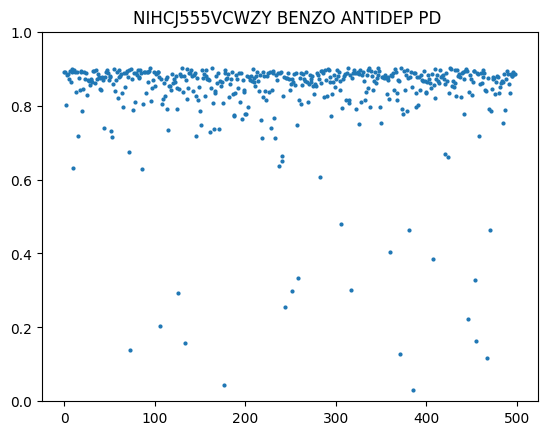

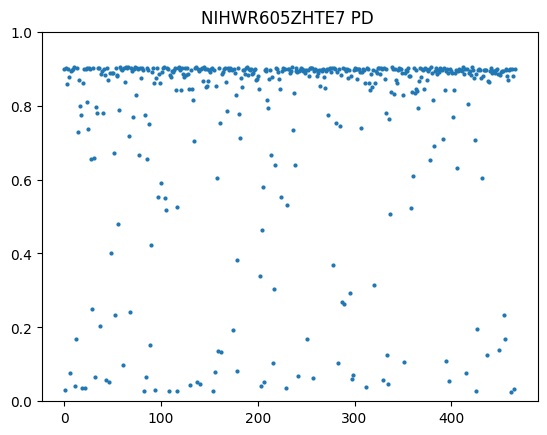

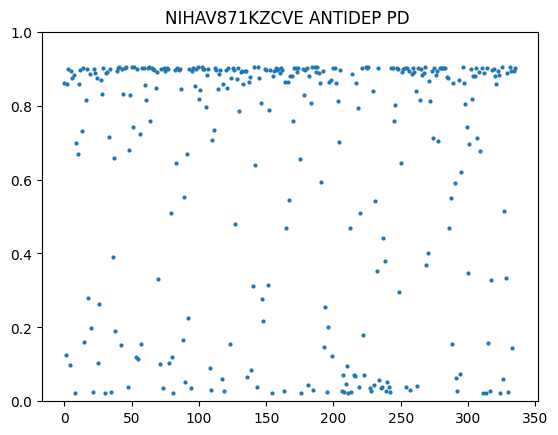

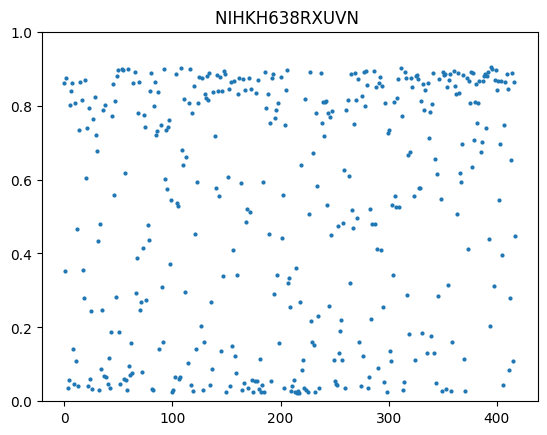

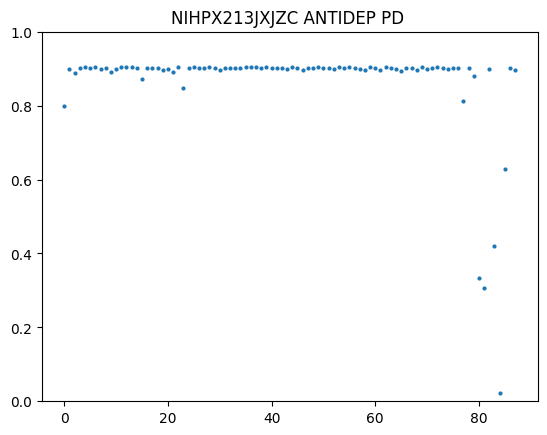

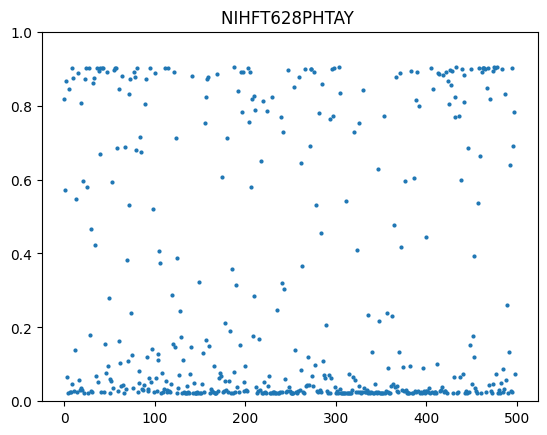

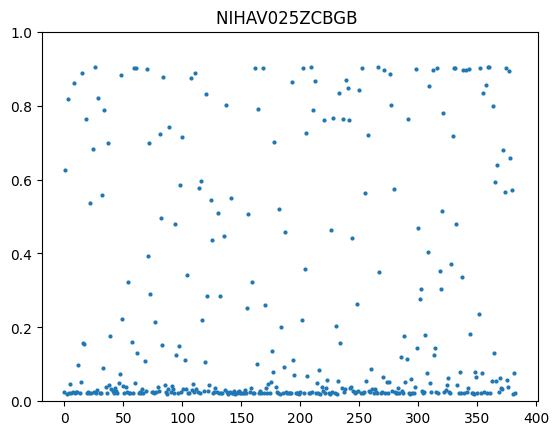

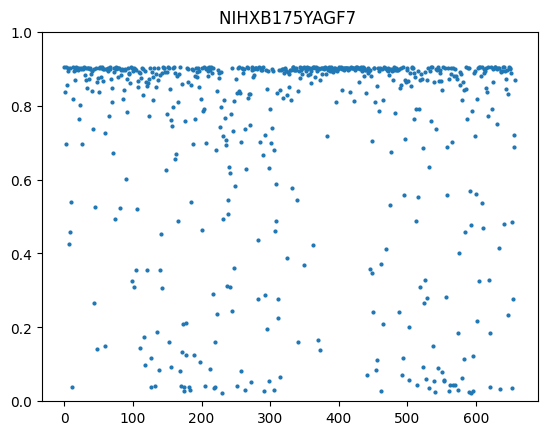

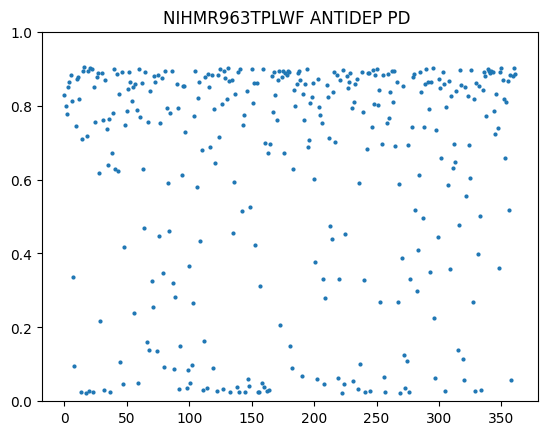

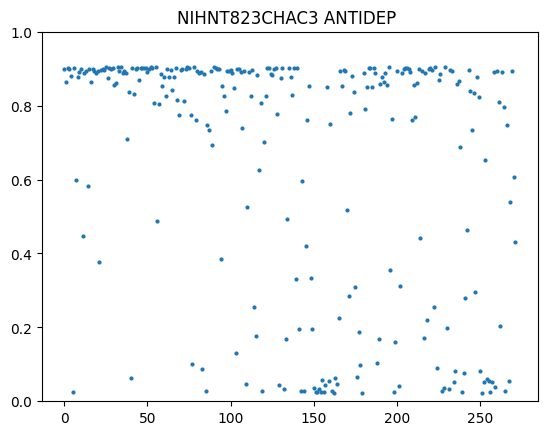

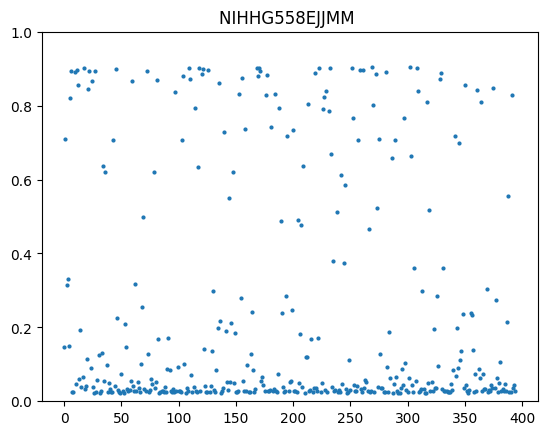

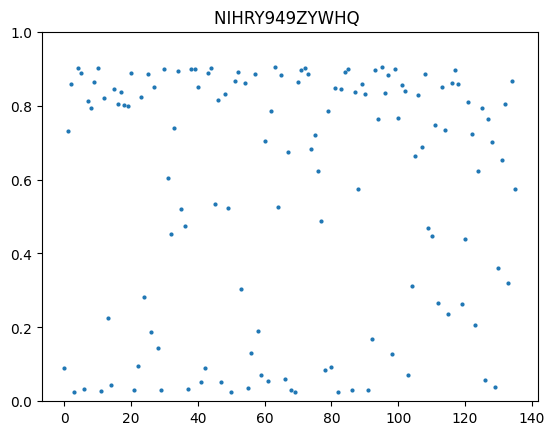

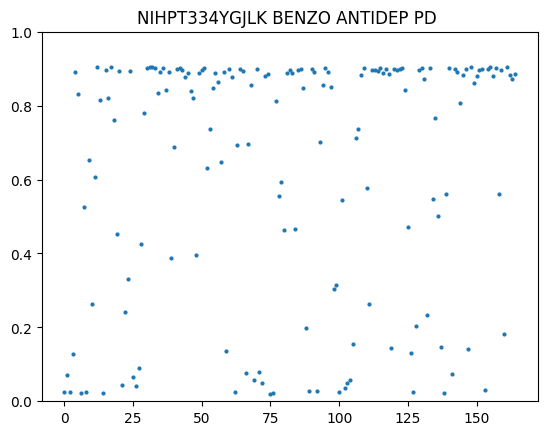

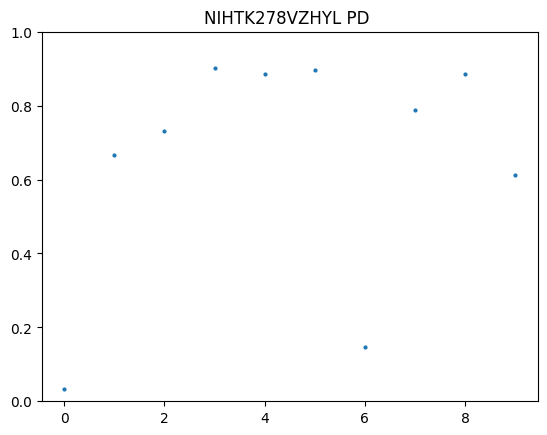

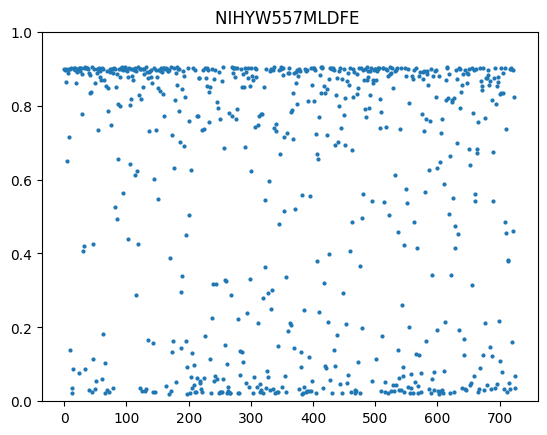

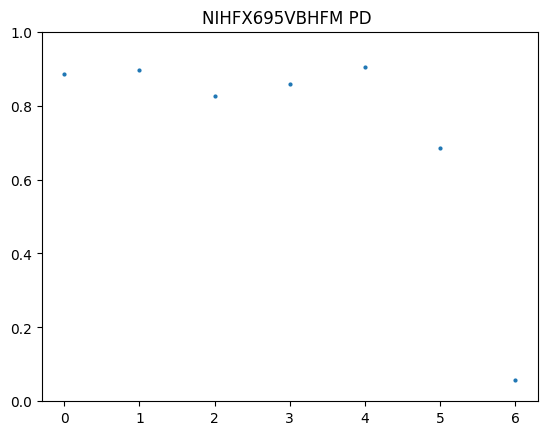

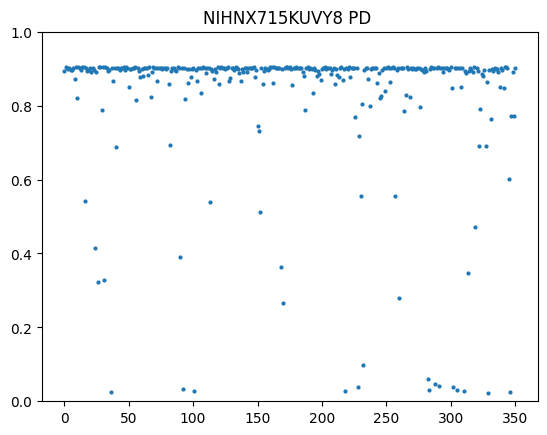

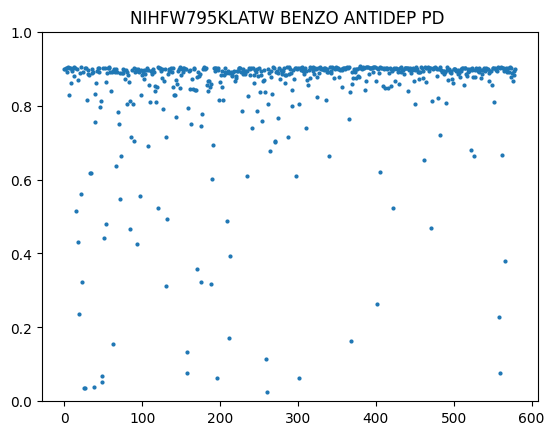

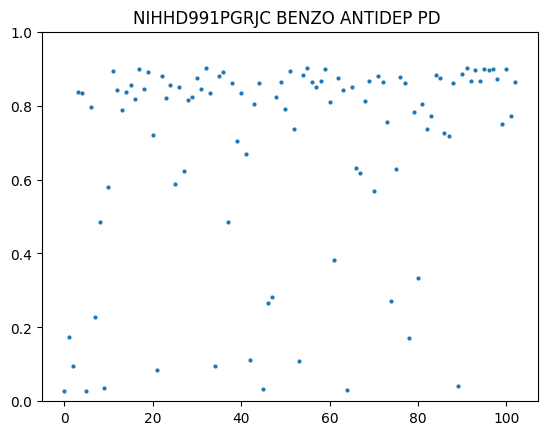

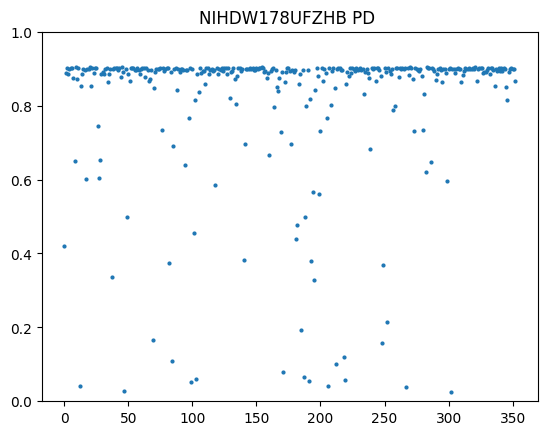

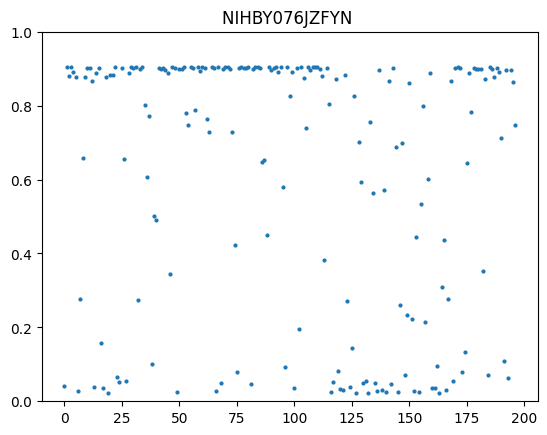

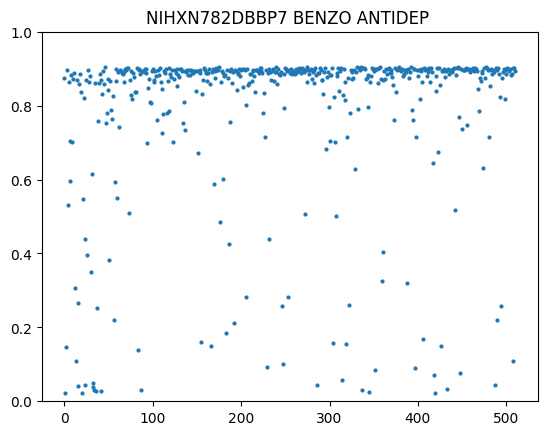

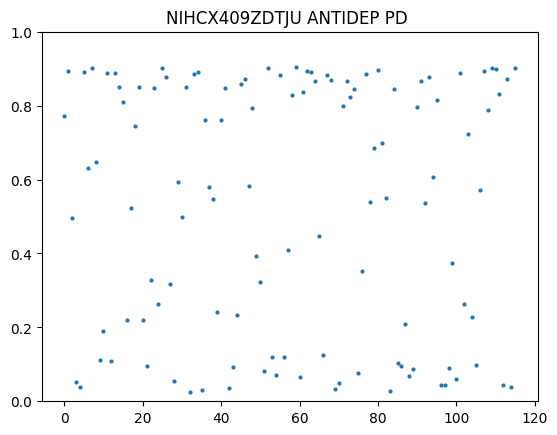

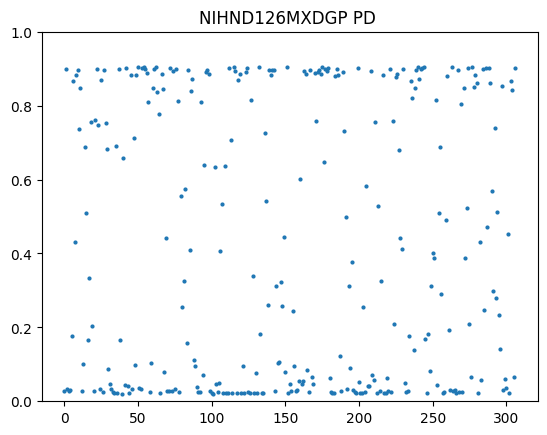

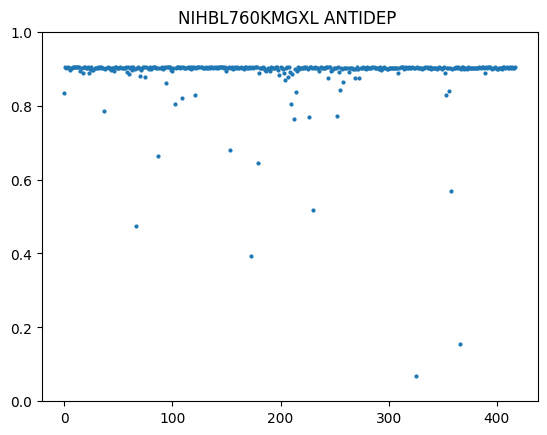

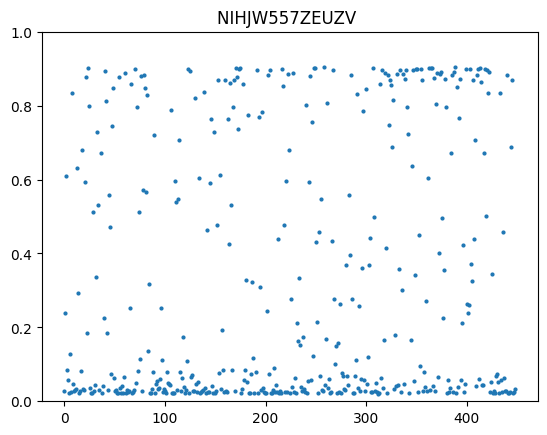

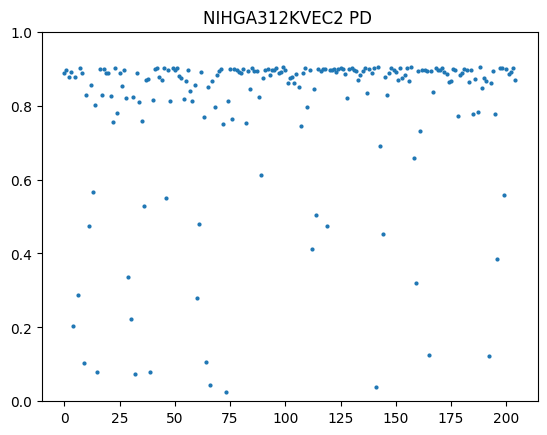

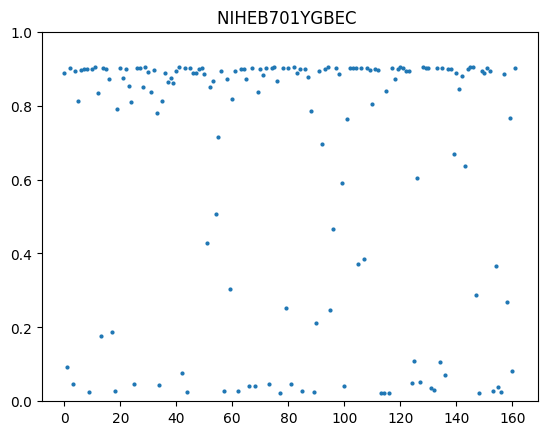

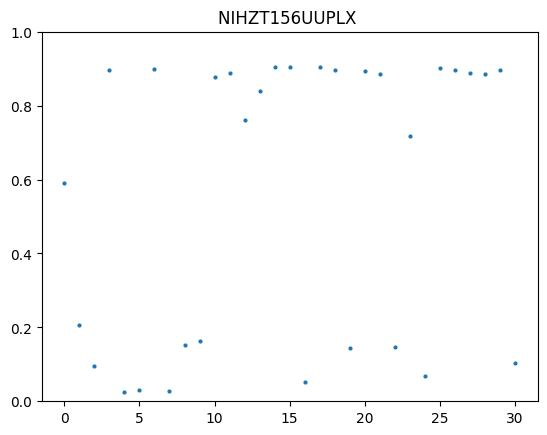

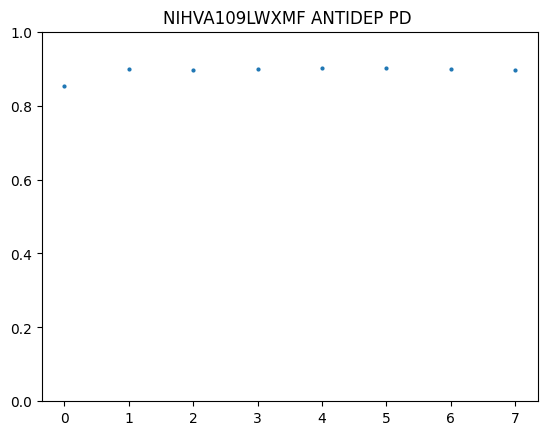

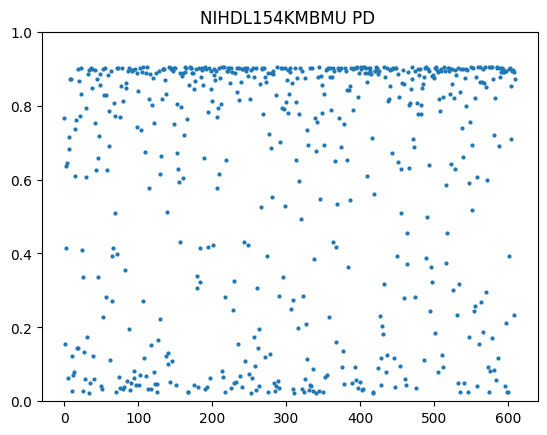

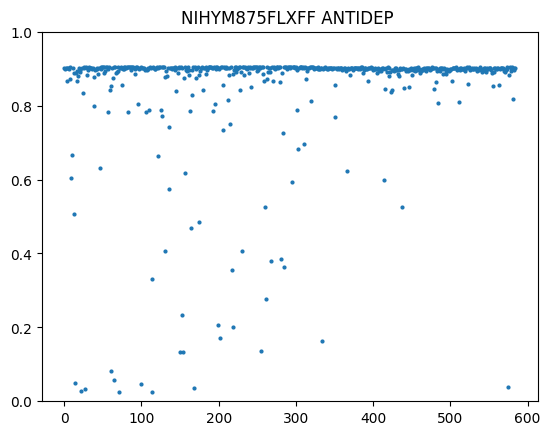

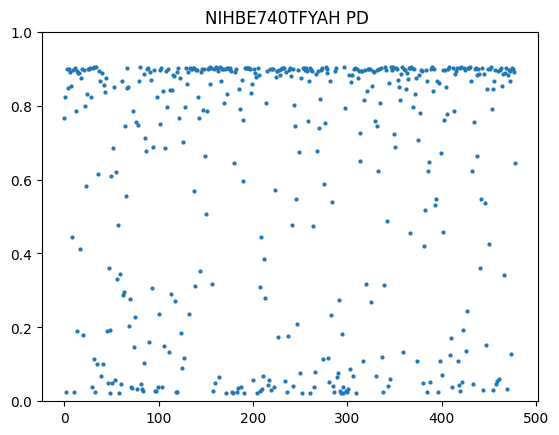

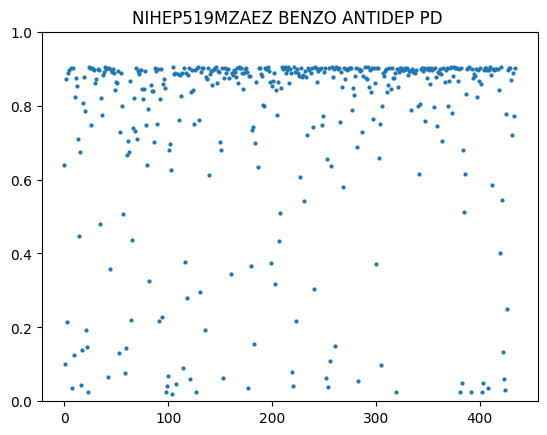

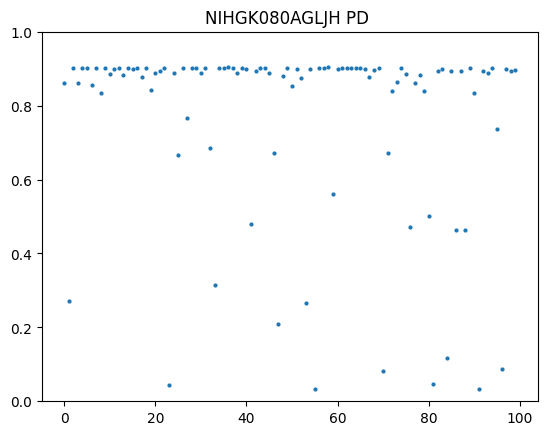

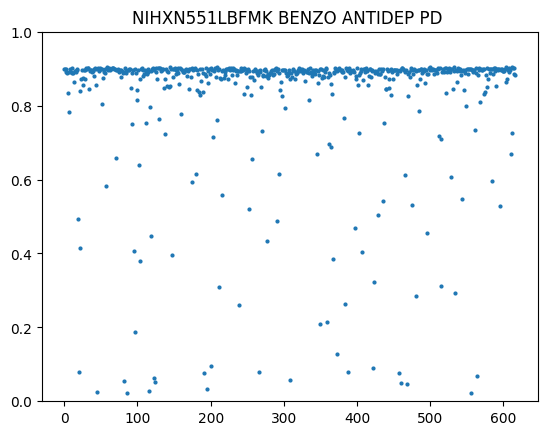

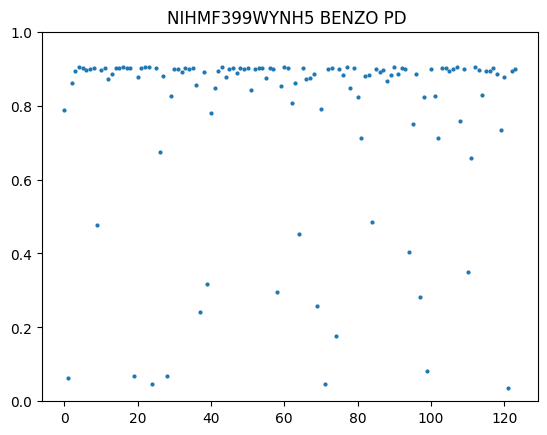

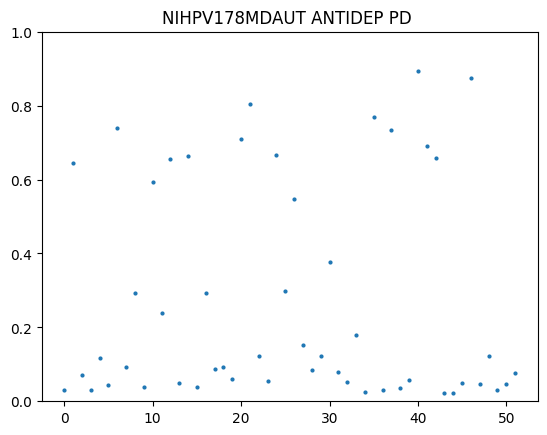

In [265]:
all_pid = []
all_benzo_score = []
all_label = []
for filename in tqdm(udall_filenames):
    patient = all_outputs[filename]
    pid = filename.split('_')[-1] 
    all_pid.append(pid)
    all_benzo_score.append(np.mean(patient['benzo_prob']))
    plt.figure()
    plt.scatter(np.arange(len(patient['benzo_prob'])),patient['benzo_prob'],s=4)
    plt.ylim(0,1)
    all_label.append(('BENZO ' if pid in BENZOS else '')+('ANTIDEP ' if antidep_dict[pid] != 'control' else '')+('PD ' if pid not in CONTROLS else ''))
    plt.title(pid + ' ' + all_label[-1])
all_pid = np.array(all_pid)
all_benzo_score = np.array(all_benzo_score)
all_label = np.array(all_label)
sort_idx = np.argsort(all_benzo_score)
ordered_output = list(zip(all_pid[sort_idx],all_benzo_score[sort_idx],all_label[sort_idx]))
for item in ordered_output:
    print(item)
plt.show()

In [125]:
print(udall_filenames)

['PD_Hao_data_NIHCJ555VCWZY', 'PD_Hao_data_NIHWR605ZHTE7', 'PD_Hao_data_NIHAV871KZCVE', 'Hao_data_NIHKH638RXUVN', 'PD_Hao_data_NIHPX213JXJZC', 'Hao_data_NIHFT628PHTAY', 'Hao_data_NIHAV025ZCBGB', 'Hao_data_NIHXB175YAGF7', 'PD_Hao_data_NIHMR963TPLWF', 'Hao_data_NIHNT823CHAC3', 'Hao_data_NIHHG558EJJMM', 'Hao_data_NIHRY949ZYWHQ', 'PD_Hao_data_NIHPT334YGJLK', 'PD_Hao_data_NIHTK278VZHYL', 'Hao_data_NIHYW557MLDFE', 'PD_Hao_data_NIHFX695VBHFM', 'PD_Hao_data_NIHNX715KUVY8', 'PD_Hao_data_NIHFW795KLATW', 'PD_Hao_data_NIHHD991PGRJC', 'PD_Hao_data_NIHDW178UFZHB', 'Hao_data_NIHBY076JZFYN', 'Hao_data_NIHXN782DBBP7', 'PD_Hao_data_NIHCX409ZDTJU', 'PD_Hao_data_NIHND126MXDGP', 'Hao_data_NIHBL760KMGXL', 'Hao_data_NIHJW557ZEUZV', 'PD_Hao_data_NIHGA312KVEC2', 'Hao_data_NIHEB701YGBEC', 'Hao_data_NIHZT156UUPLX', 'PD_Hao_data_NIHVA109LWXMF', 'PD_Hao_data_NIHDL154KMBMU', 'Hao_data_NIHYM875FLXFF', 'PD_Hao_data_NIHBE740TFYAH', 'PD_Hao_data_NIHEP519MZAEZ', 'PD_Hao_data_NIHGK080AGLJH', 'PD_Hao_data_NIHXN551LBFMK', 

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 139.53it/s]


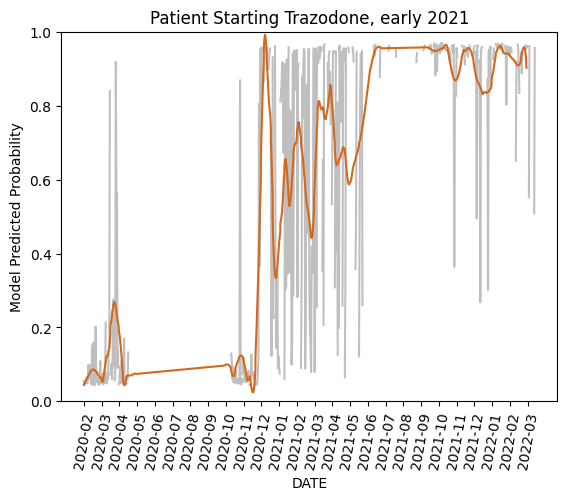

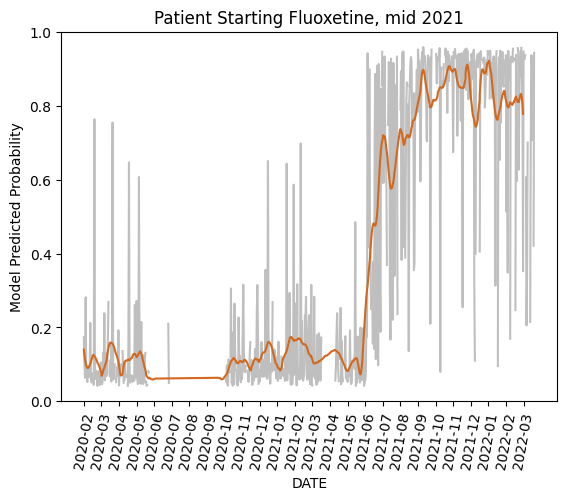

<Figure size 640x480 with 0 Axes>

In [237]:
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter
from datetime import datetime, timedelta
import scipy


med_dates = {'NIHYM875FLXFF':datetime(2021,10,24),'NIHBL760KMGXL':datetime(2021,3,1)}

def smoothed_signal(input_signal):
    aa = np.copy(input_signal)
    x_values = np.arange(len(input_signal))
    mask = ~np.isnan(input_signal)
    input_signal = input_signal[mask]
    x_values = x_values[mask]
    
    # coefficients = np.polyfit(x_values, input_signal, 5)
    x_fit = np.linspace(0, len(aa) - 1, len(aa))
    # y_fit = cs(x_fit)
    cs = scipy.interpolate.interp1d(x_values, input_signal)
    y_fit = cs(x_fit)
    

    y_fit = savgol_filter(y_fit,35,3)
    return y_fit

def add_nans(x, y):
    i = 0
    while i < len(x)-1:
        if x[i+1].date() - x[i].date() > timedelta(days=1):
            x = x[:i+1] + [x[i] + timedelta(days=1)] + x[i+1:]
            y = y[:i+1] + [np.nan] + y[i+1:]
        i += 1

    window_size = 7
    y_avg = np.zeros_like(y)
    y_avg[:] = np.nan 
    y_avg[:window_size//2] = y[:window_size//2]
    y_avg[-window_size//2:] = y[-window_size//2:]
    for i in range(window_size // 2, len(y) - window_size//2):
        if sum(np.isnan(y[i - window_size // 2:i + window_size // 2])) > window_size/2 - 1:
            y_avg[i] = np.nan
        else:
            y_avg[i] = np.nanmean(y[i - window_size // 2:i + window_size // 2])
    # savgol_filter(patient['simon_prob'],15,3)
    return x,np.array(y), y_avg

for filename in tqdm(udall_filenames):
    patient = all_outputs[filename]
    pid = filename.split('_')[-1] 
    if pid not in ['NIHYM875FLXFF','NIHBL760KMGXL']:
        continue
    titleaddon = antidep_dict[pid] + ("PD" if pid not in CONTROLS else "" )

    filenames = [item[:len('2020-02')] for item in all_dates[filename]]
    datetimes = [datetime.strptime(item[:-4],'%Y-%m-%d-%H-%M-%S') for item in all_dates[filename]]

    y = np.array(patient['simon_prob'])
    if pid == 'NIHBL760KMGXL':
        y[75:80] = np.nan
        # y[] = np.nan
        # print(list(zip(np.arange(len(y)),y)))
    x, y, smoothed_y = add_nans(datetimes, list(y))
    cs = scipy.interpolate.interp1d(np.arange(len(smoothed_y))[~np.isnan(smoothed_y)], smoothed_y[~np.isnan(smoothed_y)])
    smoothed_y = cs(np.arange(len(smoothed_y)))
    
    # smoothed_y = smoothed_signal(y)
    # plt.plot(savgol_filter(patient['stage_prob'],7,3), label='stage')
    # plt.plot(savgol_filter(patient['mage_prob'],7,3), label='mage')
    # plt.axvline(x=med_dates[pid],ls='--',color='gray')
    plt.plot(x, y, label='simon', color='gray', alpha=0.5)
    if pid == 'NIHBL760KMGXL':
        plt.plot(x[:-15], savgol_filter(smoothed_y,31,3)[:-15], label='simon2', color='chocolate')
        plt.title("Patient Starting Trazodone, early 2021")
    else: 
        plt.plot(x[:-25], savgol_filter(smoothed_y,31,3)[:-25], label='simon2', color='chocolate')
        plt.title("Patient Starting Fluoxetine, mid 2021")
    xticks = np.arange(datetimes[0],datetimes[-1],timedelta(days=30))
    plt.xticks(xticks, [str(item)[:-19] for item in xticks],rotation=80)
    plt.ylim(0,1)
    plt.ylabel('Model Predicted Probability')
    plt.xlabel('DATE')
    # plt.title(pid + titleaddon)
    # plt.legend()
    plt.figure()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1813.01it/s]


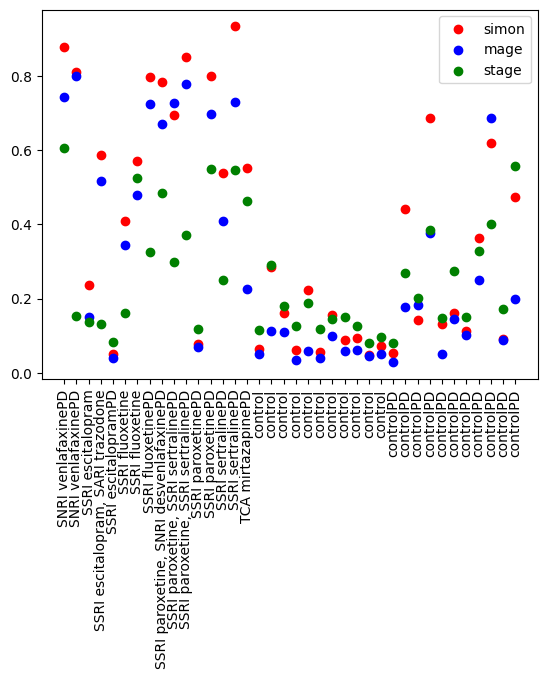

In [159]:
avg_simon = []
avg_mage = []
avg_stage = []
all_drugs = []

for filename in tqdm(udall_filenames):
    pid = filename.split('_')[-1] 
    all_drugs.append(antidep_dict[pid] + ("PD" if pid not in CONTROLS else "" ) )
    patient = all_outputs[filename]
    avg_simon.append(np.nanmean(patient['simon_prob']))
    avg_mage.append(np.nanmean(patient['mage_prob']))
    avg_stage.append(np.nanmean(patient['stage_prob']))

all_drugs = np.array(all_drugs)
# for i in range(len(all_drugs)):
#     if all_drugs[i] not in CONTROLS:
#         all_drugs[i] += " PD"
drug_sort = np.argsort(all_drugs)

avg_simon = np.array(avg_simon)[drug_sort]
avg_mage = np.array(avg_mage)[drug_sort]
avg_stage = np.array(avg_stage)[drug_sort]


plt.scatter(np.arange(len(avg_simon)), avg_simon, color='r', label='simon')
plt.scatter(np.arange(len(avg_mage)), avg_mage, color='b', label='mage')
plt.scatter(np.arange(len(avg_stage)), avg_stage, color='g', label='stage')
gg = plt.xticks(np.arange(len(avg_stage)),all_drugs[drug_sort], rotation=90)
plt.legend()


100%|███████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 134274.26it/s]
/tmp/ipykernel_3816348/797749025.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avgg_simon = np.array(avgg_simon)[drug_sort]
/tmp/ipykernel_3816348/797749025.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avgg_mage = np.array(avgg_mage)[drug_sort]
/tmp/ipykernel_3816348/797749025.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

['SARI trazodone' 'SNRI venlafaxine' 'SNRI venlafaxine'
 'SSRI escitalopram' 'SSRI escitalopram' 'SSRI escitalopram'
 'SSRI fluoxetine' 'SSRI fluoxetine' 'SSRI fluoxetine' 'SSRI paroxetine'
 'SSRI paroxetine, SNRI desvenlafaxine' 'SSRI paroxetine, SSRI sertraline'
 'SSRI paroxetine, SSRI sertraline' 'SSRI sertraline' 'SSRI sertraline'
 'TCA mirtazapine' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control']
['SSRI paroxetine']
that was 4
['SSRI paroxetine, SNRI desvenlafaxine' 'SSRI paroxetine, SSRI sertraline'
 'SSRI paroxetine, SSRI sertraline']
that was 5


/tmp/ipykernel_3816348/797749025.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


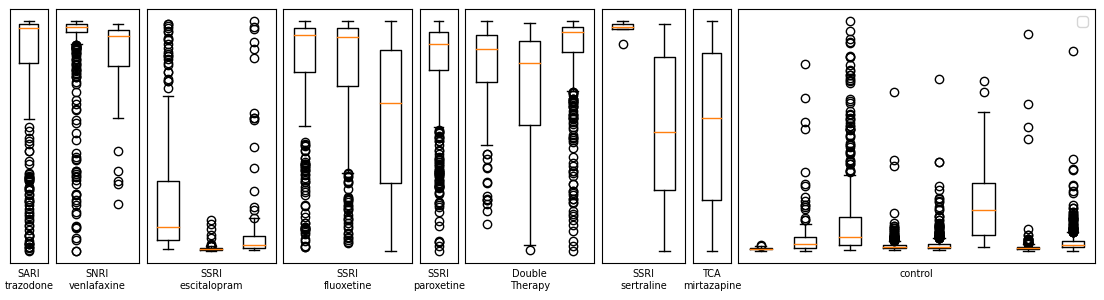

In [245]:
avgg_simon = []
avgg_mage = []
avgg_stage = []
all_drugs = []
from matplotlib.gridspec import GridSpec

for filename in tqdm(udall_filenames):
    pid = filename.split('_')[-1] 
    if antidep_dict[pid] == 'control' and pid not in CONTROLS:
        continue
    if pid == 'NIHAV871KZCVE':
        continue
    if pid == 'NIHYM875FLXFF':
        all_drugs.append("SSRI fluoxetine")
        patient = all_outputs[filename]
        avgg_simon.append(patient['simon_prob'][320:])
        avgg_mage.append(patient['mage_prob'][320:])
        avgg_stage.append(patient['stage_prob'][320:])
        continue
    if pid == 'NIHBL760KMGXL':
        all_drugs.append("SSRI escitalopram" )
        all_drugs.append("SARI trazodone" )
        patient = all_outputs[filename]
        avgg_simon.append(patient['simon_prob'][:130])
        avgg_mage.append(patient['mage_prob'][:130])
        avgg_stage.append(patient['stage_prob'][:130])
        avgg_simon.append(patient['simon_prob'][130:])
        avgg_mage.append(patient['mage_prob'][130:])
        avgg_stage.append(patient['stage_prob'][130:])
        continue
    else:
        all_drugs.append(antidep_dict[pid]) #+ ("PD" if pid not in CONTROLS else "" )  + " | " + pid)
        patient = all_outputs[filename]
        avgg_simon.append(patient['simon_prob'])
        avgg_mage.append(patient['mage_prob'])
        avgg_stage.append(patient['stage_prob'])
        continue

all_drugs = np.array(all_drugs)
# for i in range(len(all_drugs)):
#     if all_drugs[i] not in CONTROLS:
#         all_drugs[i] += " PD"
drug_sort = np.argsort(all_drugs)

avgg_simon = np.array(avgg_simon)[drug_sort]
avgg_mage = np.array(avgg_mage)[drug_sort]
avgg_stage = np.array(avgg_stage)[drug_sort]


# plt.scatter(np.arange(len(avg_simon)), avg_simon, color='r', label='simon')
# plt.scatter(np.arange(len(avg_mage)), avg_mage, color='b', label='mage')
# plt.scatter(np.arange(len(avg_stage)), avg_stage, color='g', label='stage')
# drug_mask = ["control" == drug for drug in all_drugs[drug_sort]]
# print(len(avgg_simon[drug_mask][1]))
# thing = [avgg_simon[drug_mask][0],avgg_simon[drug_mask][1][:120],avgg_simon[drug_mask][2]]
fig = plt.figure(figsize=(14,10))

gs = GridSpec(30, 24)

# Define an array that determines the width of each subplot
subplot_widths = [1,2,3,3,1,3,2,1,8]  # You can change these values as needed
print(all_drugs[drug_sort])
# Create 8 subplots with variable widths
subplots = []
col_start = 0
for i, width in enumerate(subplot_widths):
    subplot = plt.subplot(gs.new_subplotspec((0, col_start), colspan=width, rowspan=10))
    subplot.boxplot(avgg_simon[col_start:col_start+width], widths=0.5)
    subplots.append(subplot)
    # Customize each subplot as needed, for example:
    # subplot.set_title(f'Subplot {i+1}')
    subplot.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    # print(all_drugs[drug_sort][col_start:col_start+width])
    if i == 4:
        print(all_drugs[drug_sort][col_start:col_start+width])
        print('that was 4')
        
    if i == 5:
        print(all_drugs[drug_sort][col_start:col_start+width])
        print('that was 5')
        subplot.set_xlabel("Double\nTherapy", rotation=0,fontsize=7)
    else:
        labelname = all_drugs[drug_sort][col_start:col_start+width][0].replace(' ','\n')
        
        subplot.set_xlabel(labelname, rotation=0, fontsize=7)
    # subplot.set_ylabel('Y-axis')
    col_start += width

# Adjust spacing between subplots if necessary
plt.tight_layout()


# plt.ylabel('average model prediction')
# plt.xlabel('patient')
# plt.boxplot(thing)
# gg = plt.xticks(np.arange(len(drug_sort)) + 1,all_drugs[drug_sort], rotation=90)
plt.legend()
plt.show()

In [10]:
avgg_simon = []
avgg_mage = []
avgg_stage = []
all_drugs = []

for filename in tqdm(udall_filenames):
    pid = filename.split('_')[-1] 
    all_drugs.append(antidep_dict[pid] + ("PD" if pid not in CONTROLS else "" ) )
    patient = all_outputs[filename]
    avgg_simon.append(np.array(patient['simon_prob']) > 0.4 )
    avgg_mage.append(np.array(patient['mage_prob']))
    avgg_stage.append(np.array(patient['stage_prob']) > 0.1)

all_drugs = np.array(all_drugs)
drug_mask = ["control" in drug for drug in all_drugs]
aa = np.concatenate(np.array(avgg_simon)[drug_mask])
print(sum(~aa)/ len(aa))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 11543.68it/s]

0.8722410865874364



/tmp/ipykernel_3816348/654395414.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aa = np.concatenate(np.array(avgg_simon)[drug_mask])
